We have plotted the mean, variance, skewness and kurtosis in code 1. and have convinced ourselves that its right. Now i will do NN training for mean in this code


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import os
import argparse
import time

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [18]:
matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)

maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]

from scipy.interpolate import interp1d
# data Linear interpolation
dataLIFunc = interp1d(tExpTrunc, xExpTruncNormal, kind = "linear", axis=0)
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
xTrain = dataLIFunc(tTrain) 

Finding the derivative at any required point

In [19]:
dmeanBydtTemp = xTrain[1:,0]-xTrain[0:-1,0]
dvarBydtTemp = xTrain[1:,1]-xTrain[0:-1,1]
dskwBydtTemp = xTrain[1:,2]-xTrain[0:-1,2]
dkurtBydtTemp = xTrain[1:,3]-xTrain[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

dm_dt_fun = interp1d(tTrain, dmeanBydt, axis=0, fill_value='extrapolate')
dv_dt_fun = interp1d(tTrain, dvarBydt, axis=0, fill_value='extrapolate')
ds_dt_fun = interp1d(tTrain, dskwBydt, axis=0, fill_value='extrapolate')
dk_dt_fun = interp1d(tTrain, dkurtBydt, axis=0, fill_value='extrapolate')

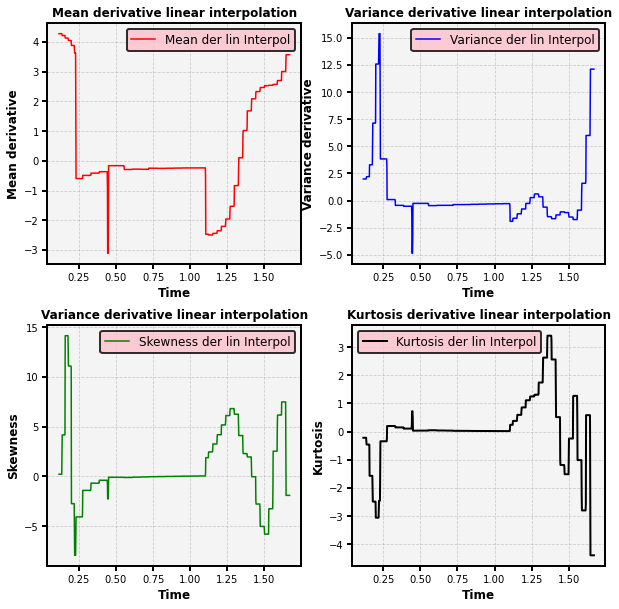

In [27]:
def common_plot_code(axs):
    #Legend and grid
    legend = axs.legend(loc = "best", fontsize= 12)
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_facecolor("pink")
    axs.grid(True, linestyle = "--", alpha=0.6)
    axs.set_facecolor("#f4f4f4")
    #tickparams
    axs.tick_params(axis = "both",length=5,width=2, direction= "out", labelsize=10)
    #bordes
    spines_dir =["top","bottom", "left", "right"]
    for spines_value in spines_dir:
        axs.spines[spines_value].set_linewidth(2)
    return 
    
fig, axs = plt.subplots(2,2,figsize=(10,10))
plt.subplots_adjust(hspace=0.25)
##Mean Plot
axs[(0,0)].plot(tTrain, dmeanBydt, "r-", label="Mean der lin Interpol")
#axis Titles
axs[(0,0)].set_title("Mean derivative linear interpolation", fontweight="bold",fontsize=12)
axs[(0,0)].set_xlabel("Time", fontweight="bold",fontsize=12)
axs[(0,0)].set_ylabel("Mean derivative", fontweight="bold", fontsize=12)
common_plot_code(axs[(0,0)])
    
## Varince Plot
axs[(0,1)].plot(tTrain, dvarBydt, "b-", label="Variance der lin Interpol")
#axis Titles
axs[(0,1)].set_title("Variance derivative linear interpolation", fontweight="bold",fontsize=12)
axs[(0,1)].set_xlabel("Time", fontweight="bold",fontsize=12)
axs[(0,1)].set_ylabel("Variance derivative", fontweight="bold", fontsize=12)
common_plot_code(axs[(0,1)])

## Skewness Plot
axs[(1,0)].plot(tTrain, dskwBydt, "g-", label="Skewness der lin Interpol")
#axis Titles
axs[(1,0)].set_title("Variance derivative linear interpolation", fontweight="bold",fontsize=12)
axs[(1,0)].set_xlabel("Time", fontweight="bold",fontsize=12)
axs[(1,0)].set_ylabel("Skewness", fontweight="bold", fontsize=12)
common_plot_code(axs[(1,0)])

## Kurtosis Plot
axs[(1,1)].plot(tTrain,dkurtBydt, "k-", linewidth=2, label= "Kurtosis der lin Interpol")
#axis Titles
axs[(1,1)].set_title("Kurtosis derivative linear interpolation", fontweight="bold",fontsize=12)
axs[(1,1)].set_xlabel("Time", fontweight="bold",fontsize=12)
axs[(1,1)].set_ylabel("Kurtosis", fontweight="bold", fontsize=12)
common_plot_code(axs[(1,1)])

plt.savefig("derivativeLinearInterpolation.pdf", bbox_inches='tight')
plt.show()